In [13]:
import numpy as np
from model import *
from dataloader import *
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import pickle

In [57]:
config = {}
config['epochs'] = 100
config['temperature'] = 1
config['num_neurons'] = 100
config['num_layers'] = 1
config['input_dim'] = None
config['learning_rate'] = 0.001
config['saved_path'] = 'Saved_weights_baseline.pth'
config['validation_loss_path'] = 'val_loss_baseline.out' 
config['training_loss_path'] = 'training_loss_baseline.out' 
config['early_stop_epoch'] = 3
config['early_stopping'] = False
config['max_song_length'] = 1000

In [63]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [64]:
train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


if not os.path.exists('one_hot_decode.pkl') or not os.path.exists('one_hot_encode.pkl'):  
    print('creating new')
    all_characters = train_file.read()
    unique_characters = list(set(all_characters))

    print((unique_characters))


    #create one hot encodings for each unique character in the alphabet of the training data
    one_hot_dict_encode = {}
    one_hot_dict_decode = {}
    index = 0
    for unique_character in unique_characters:
        current_encoding = np.zeros(config['input_dim'])
        current_encoding[index] = 1

        one_hot_dict_encode[unique_character] = current_encoding
        one_hot_dict_decode[tuple(current_encoding)] = unique_character

        index += 1


    #start token
    current_encoding = np.zeros(config['input_dim'])
    current_encoding[93] = 1

    one_hot_dict_encode['$'] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = '$'

    #end song token
    current_encoding = np.zeros(config['input_dim'])
    current_encoding[94] = 1

    one_hot_dict_encode['%'] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = '%'
    
    f = open("one_hot_decode.pkl","wb")
    pickle.dump(one_hot_dict_decode, f)
    f.close()
    
    f = open("one_hot_encode.pkl", "wb")
    pickle.dump(one_hot_dict_encode, f)
    f.close()
else : 
    print('read in saved')
    f = open("one_hot_decode.pkl","rb")
    one_hot_dict_decode = pickle.load(f)
    f.close()
    
    f = open("one_hot_encode.pkl", "rb")
    one_hot_dict_encode = pickle.load(f)
    f.close()
    
config['input_dim'] = len(one_hot_dict_decode)

print(one_hot_dict_encode.keys())

train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


#split the songs into their own strings, while including start and end tags
song = []
for line in train_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            train_songs.append(song)
            song = []
    
song = []
for line in val_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            val_songs.append(song)
            song = []

song = []
for line in test_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            test_songs.append(song)
            song = []   
            
            
len(unique_characters), len(one_hot_dict_decode)



read in saved
dict_keys(['4', 'A', '<', 't', '\t', '8', 'v', 'b', '@', '!', '^', 'K', ')', '9', 'o', 'z', 'y', 'V', 'Q', '3', 'u', '0', 'c', '\\', 'r', 'U', '+', 'p', ':', 'L', 'T', '6', '_', 'm', 'N', 'w', 'D', '>', 'i', ' ', '}', ',', 'X', 'g', 'I', 'k', 'a', '{', 'O', 'E', '*', 'x', '-', 'q', 'J', '1', '/', 'P', '.', 'Z', '7', 'd', '$', 'h', 'C', 'M', '~', 'n', '#', '?', '"', '\n', ']', '|', '&', 'F', "'", '[', 'W', 's', 'S', 'B', '2', 'e', 'G', 'j', 'l', '5', '=', 'f', 'H', 'R', 'Y', '(', '%'])


(95, 95)

In [65]:
a = np.zeros(config['input_dim'])
a[71] = 1
print(one_hot_dict_decode[tuple(a)])

In [22]:
model = Lstm(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)

    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

if not os.path.exists(config['saved_path']):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.array([0,0]))
    np.savetxt(config['validation_loss_path'], np.array([0,0]))
    
model, optimizer


(Lstm(
   (lstm_layer): LSTM(95, 100)
   (fc): Linear(in_features=100, out_features=95, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [24]:
#for early stopping
num_times_incraesed = 0
prev_val_loss = float("inf")


#restore the model's weights 
checkpoint = torch.load(config['saved_path'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch in range(config['epochs']):
    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    
    total_loss = 0

    #for early stopping
    old_net_weights = model.state_dict()
    old_optimizer = optimizer.state_dict()
    
    #metrics for train and val loss
    training_losses = np.genfromtxt(config['training_loss_path'])
    validation_losses = np.genfromtxt(config['validation_loss_path'])

    #Shuffle the songs 
    random.shuffle(train_songs)
    
    #train
    model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        cell_state = cell_state.float()
        hidden = (hidden_state, cell_state)

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = song
        
        song_loss = 0
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
           
            
            
            if len(chunk) == 0:
                break
            
            #to computing device
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            #forward
            output, hidden = model(chunk, hidden)
            

            
            #loss
            targets = targets.argmax(dim=1)
            loss = criterion(output, targets)
            song_loss += loss
            
            #backprop
            loss.backward(retain_graph=True)
            optimizer.step()
            
        total_loss += song_loss/num_minibatches
      
    #calculate training loss
    average_epoch_loss = total_loss/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with train error '+ str(average_epoch_loss.cpu().item()))


        

    total_loss = 0
    #validation
    model.eval()
    with torch.no_grad():
        for song in val_songs:
            song_loss = 0
            
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            hidden_state = hidden_state.float()
            cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            cell_state = cell_state.float()
            hidden = (hidden_state, cell_state)


            #encode the characters to their respective one hot encoding
            encoded_inputs = song


            #val
            num_minibatches = math.ceil(len(encoded_inputs)/100)
            for i in range(num_minibatches):

                chunk, targets = MyDataset(encoded_inputs)[i]
                

                if len(chunk) == 0:
                    break

                #to computing device
                chunk = chunk.to(computing_device)
                targets = targets.to(computing_device)

                #forward
                output, hidden = model(chunk, hidden)

                targets = targets.argmax(dim=1)
                
#                 print('hi')
#                 print(output.squeeze().argmax(dim=1))

#                 print('mom')
#                 print(targets)
                loss = criterion(output, targets)
                song_loss += loss
                
            total_loss += song_loss/num_minibatches

                
    #calculate training loss
    average_val_epoch_loss = total_loss/len(val_songs)
    print('epoch ' + str(epoch + 1) + ' with val error '+ str(average_val_epoch_loss.cpu().item()))
    
    
    if config['early_stopping']:
        #early stopping
        if average_val_epoch_loss > prev_val_loss:
            print('keeping old weights')
            num_times_incraesed += 1
            model.load_state_dict(old_net_weights)
            optimizer.load_state_dict(old_optimizer)
        else : 
            print('val is less than previous')
            num_times_incraesed = 0
            prev_val_loss = average_val_epoch_loss

        if num_times_incraesed >= config['early_stop_epoch']:
            print('early stopping triggered')
            break       
            
            
    #save model and loss
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.append(training_losses, average_epoch_loss.cpu().item()))
    np.savetxt(config['validation_loss_path'], np.append(validation_losses, average_val_epoch_loss.cpu().item()))
        

EPPPPOCCCHHHHH 1
epoch 1 with train error 2.7620954513549805
epoch 1 with val error 2.448500394821167
EPPPPOCCCHHHHH 2
epoch 2 with train error 1.9228054285049438
epoch 2 with val error 1.9886987209320068
EPPPPOCCCHHHHH 3
epoch 3 with train error 1.651258111000061
epoch 3 with val error 1.813874363899231
EPPPPOCCCHHHHH 4
epoch 4 with train error 1.5165067911148071
epoch 4 with val error 1.7712212800979614
EPPPPOCCCHHHHH 5
epoch 5 with train error 1.4359749555587769
epoch 5 with val error 1.738441824913025
EPPPPOCCCHHHHH 6
epoch 6 with train error 1.375138282775879
epoch 6 with val error 1.6752171516418457
EPPPPOCCCHHHHH 7
epoch 7 with train error 1.329209804534912
epoch 7 with val error 1.650712251663208
EPPPPOCCCHHHHH 8
epoch 8 with train error 1.291443109512329
epoch 8 with val error 1.6475664377212524
EPPPPOCCCHHHHH 9
epoch 9 with train error 1.2604888677597046
epoch 9 with val error 1.6252671480178833
EPPPPOCCCHHHHH 10
epoch 10 with train error 1.2332487106323242
epoch 10 with val 

KeyboardInterrupt: 

[2.44850039 1.98869872 1.81387436 1.77122128 1.73844182 1.67521715
 1.65071225 1.64756644 1.62526715 1.60870445]


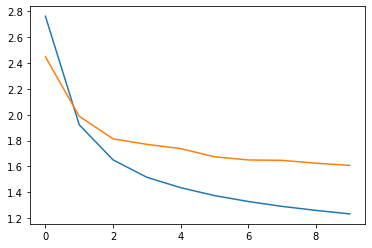

In [25]:
training_losses = np.genfromtxt(config['training_loss_path'])[2:]
validation_losses = np.genfromtxt(config['validation_loss_path'])[2:]
print(validation_losses)

x_axis = []
for i in range(len(training_losses)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_losses)
plt.plot(x_axis, validation_losses)

In [67]:
#get first initial input
output = torch.from_numpy(np.array(one_hot_dict_encode['$'])).float()[None,None,:].to(computing_device) 
                
#init hidden state
hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
hidden_state = hidden_state.float()
cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
cell_state = cell_state.float()
hidden = (hidden_state, cell_state)


new_song = []

#generate music
model.eval()
with torch.no_grad():
    while output.squeeze().argmax() != 94 or len(new_song) <= config['max_song_length']: 
        output, hidden = model(output, hidden)
        
        softmax = F.softmax(output/config['temperature'])
        
        start = 0
        partitions = []
        
        for i in softmax[0]:
            partitions.append((start, start + i.item()))
            start = start + i.item()
        
        roll = random.uniform(0, partitions[-1][1])
        
        
        guess = 0
        for partition in partitions:
            if roll >= partition[0] and roll < partition[1]:
                break
            else : 
                guess += 1
        
        print(len(new_song))

        next_input = np.zeros(config['input_dim'])
        next_input[guess] = 1
        
        new_song.append(next_input)
        
        output = torch.from_numpy(next_input).float()[None, None, :].to(computing_device)
                
        
for encoding in new_song:
    print(one_hot_dict_decode[tuple(encoding)])
            
        
        
      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27